In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sn
import pandas as pd
import tensorflow as tf
import sklearn
import shutil


from tensorflow.keras.preprocessing.image import ImageDataGenerator


SEED = 123                 # to be able to rerun the same NN
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!mkdir working

In [ ]:
ROOT = "working"

In [ ]:
PATH_TO_RESOURCES = "/content/drive/MyDrive/data"

In [ ]:
path_train = ROOT + "/train"
path_test = ROOT + "/test"

In [ ]:
!mkdir -p $ROOT/train

In [ ]:
!cp -r $PATH_TO_RESOURCES/high/* $path_train

In [ ]:
!ls $path_train

pe-hd-opaque	     pet-clair	 pet-fonce   pp
pet-barquette-clair  pet-colore  pet-opaque


In [ ]:
NB_IMAGES_PER_CLASS = 1858

In [ ]:
import skimage
from skimage import io


def is_rgb_shape(im):
    return len(im.shape) == 3 and im.shape[2] == 3

def get_info_clean_data(path, nb_max):
    """
    Load data from a directory
    Get info of the data
    Clean the data if necessary
    
    Return:
        * A list of images
        * A list of labels corresponding to the list of images
        * A dataframe describing the images
        * A map of label to class/category name
    """
    curr_label = 0
    label_to_category = dict()

    labels = []
    imgs = []
    info = []

    for dirname in np.sort(os.listdir(path)):
        label_to_category[curr_label] = dirname
        dirname = os.path.join(path, dirname)
        
        curr_file = 0
        for filename in os.listdir(dirname):
            
            if curr_file >= nb_max:
                break
            
            filename = os.path.join(dirname, filename)

            img = skimage.io.imread(filename)
            # The image is not an rgb image and thus not append
            # The dataset doesn't seem to have such images though
            if not is_rgb_shape(img):
                print("not is_rgb_shape")
                os.remove(filename)
                continue

            imgs.append(img)
            info.append([filename, curr_label, img.shape[0], img.shape[1], img.dtype])
            labels.append(curr_label)
            curr_file += 1

        curr_label += 1

    labels = np.array(labels)
    df_input = pd.DataFrame(info, columns = ["filename", "category", "width", "height", "dtype"])
    return np.array(imgs), labels, df_input, label_to_category

In [ ]:
imgs, labels, df_input, label_to_category = get_info_clean_data(path_train, NB_IMAGES_PER_CLASS)

In [ ]:
len(imgs)

11519

In [ ]:
labels

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
label_to_category

{0: 'pe-hd-opaque',
 1: 'pet-barquette-clair',
 2: 'pet-clair',
 3: 'pet-colore',
 4: 'pet-fonce',
 5: 'pet-opaque',
 6: 'pp'}

In [ ]:
df_input

,filename,category,width,height,dtype
0,working/train/pe-hd-opaque/2020-06-04-17-11-09...,0,200,300,uint8
1,working/train/pe-hd-opaque/2019-04-05-10-43-42...,0,200,300,uint8
2,working/train/pe-hd-opaque/2019-05-17-17-32-45...,0,200,300,uint8
3,working/train/pe-hd-opaque/2019-04-15-17-55-10...,0,200,300,uint8
4,working/train/pe-hd-opaque/2020-02-05-16-18-08...,0,200,300,uint8
...,...,...,...,...,...
11514,working/train/pp/2020-06-23-18-41-23-972158-CA...,6,200,300,uint8
11515,working/train/pp/2019-05-25-09-34-02-481540-CA...,6,200,300,uint8
11516,working/train/pp/2020-04-07-13-49-39-447785-CA...,6,200,300,uint8
11517,working/train/pp/2020-07-21-18-57-16-814237-CA...,6,200,300,uint8


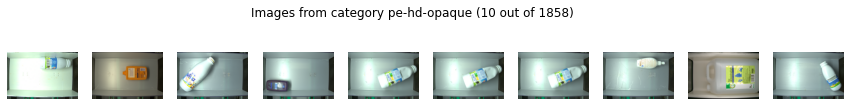

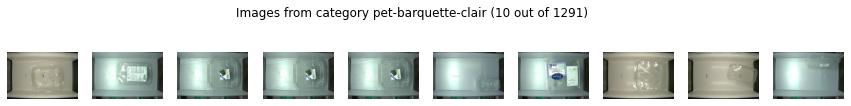

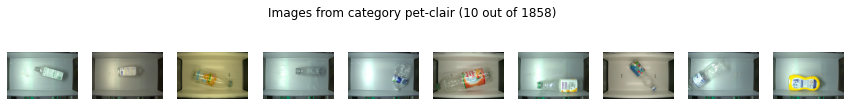

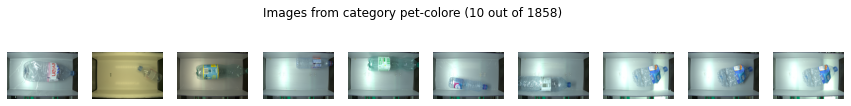

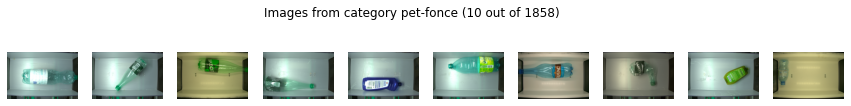

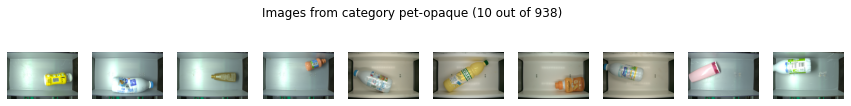

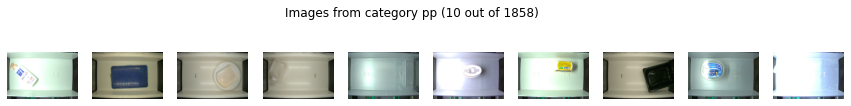

In [ ]:
nb_images_per_class_to_show = 10

for i in range(len(label_to_category)):
    
    index = np.argmax(labels == i)
    count = np.count_nonzero(labels == i)
    pos = 1
    
    plt.figure(figsize=[15, 2])
    fig = plt.gcf()
    fig.suptitle("Images from category {} ({} out of {})".format(label_to_category[i],
                                                                 nb_images_per_class_to_show,
                                                                 count))
    
    for l in range(index, index + nb_images_per_class_to_show):
        plt.subplot(1, nb_images_per_class_to_show, pos)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[l])
        plt.axis('off')
        pos += 1

    plt.show()

[]

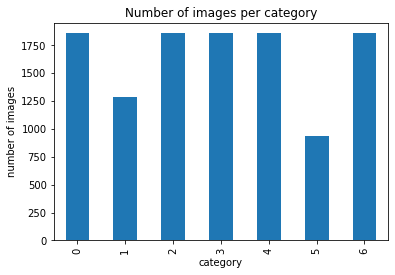

In [ ]:
# Plot number of images per category
ax = df_input.category.value_counts(sort=False).plot.bar()
ax.set_xlabel('category')
ax.set_ylabel('number of images')
ax.set_title("Number of images per category")
ax.plot()

In [ ]:
!mkdir -p $ROOT/test

In [ ]:
def setup_data(dir_input, dir_output, label_to_category, nb_test_img_per_category = None):
    """
    Move some images from an input directory to an output directory
    
    Arguments:
        * dir_input: the input directory
        * dir_output: the output directory
        * label_to_category: used to get the category name (thus the directory name)
        * nb_test_img_per_category: number of images per category
    """
    for label, class_name in label_to_category.items():
        class_path = os.path.join(dir_input, class_name)
        new_class_path = os.path.join(dir_output, class_name)
        try:
            os.mkdir(new_class_path)
        except FileExistsError:
            os.rmdir(new_class_path)
            os.mkdir(new_class_path)
        
        # If None, move everything
        for filename in os.listdir(class_path)[:nb_test_img_per_category]:
            #os.rename(os.path.join(class_path, filename), os.path.join(new_class_path, filename))
            shutil.move(os.path.join(class_path, filename), os.path.join(new_class_path, filename))

In [ ]:
# Test data will have 100 of images for each category
#setup_data(path_train, path_test, label_to_category, nb_test_img_per_category=100)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from pathlib import Path
import glob


def load_test_set(TRAIN_PATH, TEST_PATH, CATEGORIES, NB_TEST_IMAGES_PER_CLASS, IMG_DIM):
    # Create test dir
    Path(TEST_PATH).mkdir(exist_ok=True)
    nb_classes = len(CATEGORIES)

    X_test = np.empty((nb_classes * NB_TEST_IMAGES_PER_CLASS, IMG_DIM[0], IMG_DIM[1], 3))
    Y_test = np.empty((nb_classes * NB_TEST_IMAGES_PER_CLASS, nb_classes))

    sample_index = 0
    for category_index, category in CATEGORIES.items():
        # Get filenames of NB_TEST_IMAGES_PER_CLASS for each category
        images_path = glob.glob(TRAIN_PATH + category + '/*.jpg')
        images_path = images_path[0 : NB_TEST_IMAGES_PER_CLASS]

        Path(TEST_PATH + category).mkdir(exist_ok = True)

        for path in images_path:
            # Load and, normalize and resize image
            img = Image.open(path)
            img = img.resize((IMG_DIM[1], IMG_DIM[0]), Image.NEAREST)
            img = np.array(img) / 255.0

            #  Convert grayscale images to RGB
            if len(img.shape) == 2:
                img = np.stack([img] * 3, axis=-1)

            # Store image and label value
            X_test[sample_index] = img
            Y_test[sample_index] = to_categorical(category_index, num_classes = nb_classes)
            sample_index += 1

            # Move image outside of training set directory
            dst_path = Path(path.replace('train', 'test'))
            Path(path).replace(dst_path)

    # Shuffle X_test and Y_test
    X_test, Y_test = shuffle(X_test, Y_test)
    return X_test, Y_test

In [ ]:
#Test data will have 100 of images for each category
X_test, Y_test = load_test_set(path_train, path_test, label_to_category, 100, [df_input.width[0], df_input.height[0]])

In [ ]:
!ls $ROOT/test

pe-hd-opaque	     pet-clair	 pet-fonce   pp
pet-barquette-clair  pet-colore  pet-opaque


In [ ]:
path_gen_test = ROOT + "/path_gen_test"
!mkdir $path_gen_test

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

# Categories are sorted by alphabetical order
test_generator = test_datagen.flow_from_directory(
        path_test,
        seed = SEED,
        shuffle = False,
        save_to_dir = path_gen_test,
        save_format = "jpeg",
        interpolation = "bicubic")

Found 700 images belonging to 7 classes.


In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 20,
        brightness_range = [0.3,1.0],
        validation_split = 0.1
)

BATCH_SIZE = 64
SHAPE = (224, 224)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        directory = path_train,
        target_size = SHAPE,
        batch_size = BATCH_SIZE,
        subset = "training",
        class_mode = "categorical")

validation_generator = train_datagen.flow_from_directory(
        directory = path_train,
        target_size = SHAPE,
        batch_size = BATCH_SIZE,
        subset = "validation",
        class_mode = "categorical",
        shuffle = False
    )

Found 23738 images belonging to 7 classes.
Found 2634 images belonging to 7 classes.


In [ ]:
from sklearn.utils import class_weight

class_weights_arr = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_generator.classes), 
    y = train_generator.classes
)

class_weights = dict(enumerate(class_weights_arr))

In [ ]:
input_shape = (SHAPE + (3,))
outputShape = 7

In [ ]:
input_shape

(224, 224, 3)

<h2>Creating the ANN</h2>

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Flatten, 
    Dense,
    GlobalAveragePooling2D, 
    Dropout
)
from tensorflow.keras.models import Model, Sequential

with mirrored_strategy.scope():
    base_model = VGG16(weights = "imagenet", include_top = False)

    x = base_model.get_layer('block5_conv3').output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(outputShape, activation = 'sigmoid')(x)

    model = Model(inputs = base_model.inputs, outputs = x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
print("Nombre de couches : ", len(base_model.layers))

Nombre de couches :  19


In [ ]:
print("Nombre de couches : ", len(model.layers))
model.summary()

Nombre de couches :  22
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, N

<h2>Training The ANN: Transfer Learning</h2>

<h3>Frozen weight pre-training</h3>

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import clone_model

for layer in base_model.layers:
    layer.trainable = False

#optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
optimizer = Adam()

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Callbacks used:

* **ModelCheckpoint**: keep the best weights by creating a checkpoint every time the validation loss improves.
* **EarlyStopping**: stop the training to avoid overfitting if the validation loss does not decrease after 5 epochs.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath,
                                            save_weights_only = True,
                                            monitor = 'val_accuracy',
                                            mode = 'max',
                                            save_best_only = True,
                                            verbose = 1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_earlystop_callback = EarlyStopping(monitor = 'val_accuracy',
                                         patience = 5,
                                         verbose = 1)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [ ]:
nb_epochs = 10


history = model.fit(train_generator,
                    validation_data = validation_generator,
                    class_weight = class_weights,
                    epochs = nb_epochs,
                    callbacks = [model_checkpoint_callback, model_earlystop_callback])

Epoch 1/10
371/371 [==============================] - ETA: 0s - loss: 1.4751 - accuracy: 0.4401
Epoch 00001: val_accuracy improved from -inf to 0.36598, saving model to model_checkpoint
371/371 [==============================] - 375s 1s/step - loss: 1.4751 - accuracy: 0.4401 - val_loss: 1.5585 - val_accuracy: 0.3660
Epoch 2/10
371/371 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.4949
Epoch 00002: val_accuracy improved from 0.36598 to 0.38573, saving model to model_checkpoint
371/371 [==============================] - 376s 1s/step - loss: 1.3052 - accuracy: 0.4949 - val_loss: 1.5160 - val_accuracy: 0.3857
Epoch 3/10
371/371 [==============================] - ETA: 0s - loss: 1.2210 - accuracy: 0.5281
Epoch 00003: val_accuracy did not improve from 0.38573
371/371 [==============================] - 383s 1s/step - loss: 1.2210 - accuracy: 0.5281 - val_loss: 1.5279 - val_accuracy: 0.3743
Epoch 4/10
371/371 [==============================] - ETA: 0s - loss: 1.1565 -

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    
with mirrored_strategy.scope():
    optimizer = Adam(lr = 1e-5)

    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.models import load_model

model.save('model-03.h5')

In [ ]:
#model = load_model("model/model-02/model.h5")

<h3>Unfrozen full training</h3>

In [ ]:
history2 = model.fit(x = train_generator,
                     validation_data = validation_generator,
                     class_weight = class_weights,
                     epochs = 500,
                     callbacks = [model_checkpoint_callback, model_earlystop_callback])

Epoch 1/500
371/371 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.7239
Epoch 00001: val_accuracy improved from 0.49127 to 0.65072, saving model to model_checkpoint
371/371 [==============================] - 392s 1s/step - loss: 0.7389 - accuracy: 0.7239 - val_loss: 0.9444 - val_accuracy: 0.6507
Epoch 2/500
371/371 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8289
Epoch 00002: val_accuracy improved from 0.65072 to 0.71488, saving model to model_checkpoint
371/371 [==============================] - 386s 1s/step - loss: 0.4764 - accuracy: 0.8289 - val_loss: 0.9550 - val_accuracy: 0.7149
Epoch 3/500
371/371 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.8724
Epoch 00003: val_accuracy improved from 0.71488 to 0.83713, saving model to model_checkpoint
371/371 [==============================] - 384s 1s/step - loss: 0.3679 - accuracy: 0.8724 - val_loss: 0.5239 - val_accuracy: 0.8371
Epoch 4/500
371/371 [=============

In [ ]:
model.save('model-500ep.h5')

In [ ]:
hist_frozen_df = pd.DataFrame(history.history) 
hist_unfrozen_df = pd.DataFrame(history2.history) 
hist_df = pd.concat([hist_frozen_df, hist_unfrozen_df])
hist_df.head(5)

,loss,accuracy,val_loss,val_accuracy
0,1.475103,0.440096,1.558496,0.365983
1,1.305194,0.494945,1.515988,0.385725
2,1.221003,0.528098,1.527890,0.374336
3,1.156532,0.557882,1.434037,0.443432
4,1.111022,0.570857,1.382568,0.444191


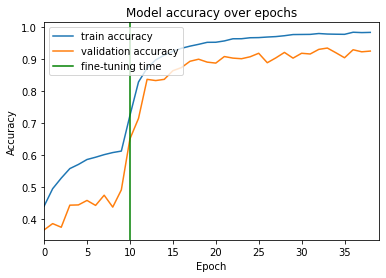

In [ ]:
plt.plot(hist_df.accuracy.to_numpy())
plt.plot(hist_df.val_accuracy.to_numpy())
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, hist_df.index.size])
plt.axvline(x = nb_epochs, color = 'green')
plt.legend(['train accuracy', 'validation accuracy', 'fine-tuning time'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
metrics = model.evaluate(test_generator)
print("The model accuracy over the test data %.2f%%"%(metrics[1] * 100))

In [ ]:
model.save('model2-500ep.h5')

In [ ]:
from tensorflow.keras.models import save_model

model_dir = ROOT + "/model/"

try:
    dirlist = os.listdir(model_dir)
except FileNotFoundError:
    os.mkdir(model_dir)

if len(dirlist) == 0:
    iteration = "01"
else:
    last_iteration = int(dirlist[-1].split("-")[1])
    iteration = "{:02d}".format(last_iteration + 1)

save_dir = model_dir + "model-" + iteration + "/"
os.mkdir(save_dir)

save_model(model, save_dir + "model.h5", save_format="h5")
hist_df = pd.DataFrame(history.history) 
hist_csv_file = save_dir + "history.csv"

with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
#from tensorflow.keras.models import load_model

#model = load_model("result/model2-500ep.h5")

In [ ]:
#model.summary()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = validation_generator.classes

In [ ]:
from glob import glob

target_names = [os.path.basename(path) for path in glob(path_train + "/*")]

print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def my_plot_confusion_matrix(conf_matrix, classes, title=None):
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=(10,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)
    #sn.heatmap(df_cm, cmap='Oranges', annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title:
        plt.title(title)

In [ ]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix of the model
y_pred = model.predict(test_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [ ]:
my_plot_confusion_matrix(conf_matrix, label_to_category.values(), title="Confusion matrix from the model prediction")

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
from sklearn.metrics import classification_report

Y_test_pred = model.predict(X_test).argmax(axis=-1)

report = classification_report(Y_test.argmax(axis=-1),
                               Y_test_pred,
                               target_names=CATEGORIES,
                               zero_division=0)

print(report)

In [ ]:
cm = confusion_matrix(Y_test.argmax(axis=-1), Y_test_pred)

plot_confusion_matrix(cm,
                      class_names=CATEGORIES,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10))

In [ ]:
def plot_errors(X, Y, Y_pred, nb_images=30, CATEGORIES):
    plt.figure(figsize=(10, 15))
    
    pos_in_figure = 0
    for i in range(len(X)):
        if pos_in_figure >= nb_images:
            break

        if Y[i] == Y_pred[i]: # Skip correct predictions
            continue

        label_pred = CATEGORIES[Y_pred[i]]
        label_actual = CATEGORIES[Y[i]]
            
        plt.subplot(10, 5, pos_in_figure + 1)
        plt.imshow(X[i])            
        plt.title("Actual={}\n Pred={}".format(label_actual, label_pred))
        plt.axis("off")
        
        pos_in_figure += 1
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Show errors made by the model
plot_errors(X_test, Y_test.argmax(axis=-1), Y_test_pred, label_to_category)

In [ ]:
#from sklearn.metrics import classification_report

#print(classification_report(test_generator.classes, y_pred, target_names=label_to_category.values()))

In [ ]:
#def plot_errors(X, Y, Y_pred, nb_images=30):
#    plt.figure(figsize=(10, 15))
#    
#    pos_in_figure = 0
#    for i in range(len(X)):
#        if pos_in_figure >= nb_images:
#            break
#
#        if Y[i] == Y_pred[i]: # Skip correct predictions
#            continue
#
#        label_pred = CATEGORIES[Y_pred[i]]
#        label_actual = CATEGORIES[Y[i]]
#            
#        plt.subplot(10, 5, pos_in_figure + 1)
#        plt.imshow(X[i])            
#        plt.title("Actual={}\n Pred={}".format(label_actual, label_pred))
#        plt.axis("off")
#        
#        pos_in_figure += 1
#    
#    plt.tight_layout()
#    plt.show()

In [ ]:
# Show errors made by the model
#plot_errors(X_test, Y_test.argmax(axis=-1), Y_test_pred)

In [ ]:
#plt.figure(figsize=(16,4))
#for ii, (img, y_pred, y_true) in enumerate(zip(meme_test_imgs, y_pred_meme_test, y_true_meme_test)):
#    plt.subplot(2, 8, ii+1)
#    correct = y_pred == y_true
#    show_image(img, 'g' if correct else 'r')
#    plt.title(("CHI" if y_true == 0 else "MUF") + " " + ("OK" if correct else "ERR"))